Question 1:
How has the public perception of anti-vaccine conspiracy via YouTube changed during the last five years?

In [13]:
import sys

!{sys.executable} -m pip install spacy

!{sys.executable} -m spacy download en_core_web_sm

!{sys.executable} -m pip install --upgrade scipy --no-cache-dir

!{sys.executable} -m pip uninstall numpy -y
!{sys.executable} -m pip install numpy==1.24.4 --no-cache-dir

!{sys.executable} pip install pandas==1.5.3 --no-cache-dir


  Using cached numpy-2.2.6-cp310-cp310-win_amd64.whl.metadata (60 kB)
Using cached numpy-2.2.6-cp310-cp310-win_amd64.whl (12.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled numpy-1.24.4
  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
Found existing installation: numpy 2.2.6
Uninstalling numpy-2.2.6:
  Successfully uninstalled numpy-2.2.6
   ---------------------------------------- 14.8/14.8 MB 13.3 MB/s  0:00:01


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.4 which is incompatible.
C:\Users\49152\AppData\Local\Programs\Python\Python310\python.exe: can't open file 'c:\\Users\\49152\\Desktop\\DataDivas\\quest1\\pip': [Errno 2] No such file or directory


In [1]:
import numpy as np
print(np.__version__)

1.24.4


In [14]:
import pandas as pd
import json

import ast
from collections import Counter

import spacy

import re

data = pd.read_csv('one.csv')

# The next line cleans the data by removing duplicate lines.
data.drop_duplicates(inplace = True)

data['Published At'] = pd.to_datetime(data['Published At'])

time_periods = [
    ('2020', '2020-01-01', '2020-12-31'),
    ('2021', '2021-01-01', '2021-12-31'),
    ('2022', '2022-01-01', '2022-12-31'),
    ('2023', '2023-01-01', '2023-12-31'),
    ('2024', '2024-01-01', '2024-12-31'),
    ('2025', '2025-01-01', '2025-12-31'),
]
result = {}

for name, start, end in time_periods:
    filter = (data['Published At'] >= start) & (data['Published At'] <= end)
    filtered = data[filter]

    text = ' '.join(filtered['TOP 10 comments'].astype(str).tolist())

    text = re.sub(r"[\(\)\[\]',\"]", "", text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # entfernt alles, was kein Buchstabe oder Leerzeichen ist
    text = text.lower()

    nlp = spacy.load('en_core_web_sm')
    stop_words = nlp.Defaults.stop_words

    ignore_words = ['people','im','dont','going','got','think','time','like']
    all_stopwords = stop_words.union(ignore_words)

    words = text.lower().split()
    filtered_words = [word for word in words if word not in all_stopwords]

    keywords = Counter(filtered_words).most_common(15)

    result[name] = {
        'keywords' : (keywords)
    }

with open('answer_one.json', 'w', encoding='utf-8') as file:
    json.dump(result, file, indent=2)

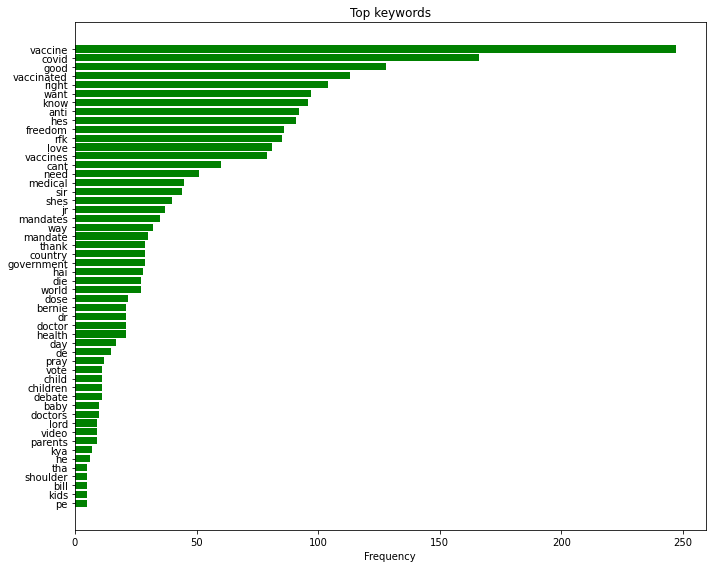

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

import json
from collections import defaultdict

with open('answer_one.json', 'r', encoding='utf-8') as file:
    keywords = json.load(file)

frequencies_all_years = defaultdict(int)

for year, content in keywords.items():
    for keyword, frequency in content['keywords']:
        frequencies_all_years[keyword] += frequency

data = pd.DataFrame(frequencies_all_years.items(), columns=['Keyword', 'Frequency'])
data = data.sort_values(by='Frequency', ascending=True)

plt.figure(figsize=(10,8))
plt.barh(data['Keyword'], data['Frequency'], color='green')
plt.xlabel('Frequency')
plt.title(f'Top keywords')
plt.tight_layout()
plt.show()

